**Titanic Solution 1**

This notebook is my first solution to predict survivors aboard the Titanic. Kaggle pre-split the training and test datasets. The training set includes 891 observations and 12 features, and the test set consists of 418 observations and 11 features. I used fifteen percent of the training set for a validation set due to limited observations. The features used in this analysis include age, gender(Sex), ticket class(Pclass), number of family members(Family), and fare. This notebook fits a random forest and a logistic regression model to the dataset. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np                                         # Linear algebra
import pandas as pd                                        # Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                            # Plots
from sklearn.ensemble import RandomForestClassifier        # Random forest
from sklearn import metrics                                # Accuracy measurement
from sklearn.metrics import plot_confusion_matrix          # Confusion matrix evaluation
from sklearn.linear_model import LogisticRegression        # Logistic regression
from sklearn.metrics import classification_report          # Regression classification report
from sklearn.model_selection import RandomizedSearchCV     # Tune decision tree params
from sklearn.ensemble import RandomForestRegressor         # Tune decision tree params
from sklearn.model_selection import GridSearchCV           # Tune params

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


The sections below read the data and check for missing variables. 

In [2]:
# Read data 
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Describe data
train_df.describe()
# Get size 
print(f"Rows: {train_df.shape[0]}, Cols: {train_df.shape[1]}")

Rows: 891, Cols: 12


In [4]:
# Check how many missing values in train dataset
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
# Check how many missing values in test dataset
print(test_df.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


The sections below handle the missing values in the datasets and create a family variable with the sibling and parent variables. The cabin feature contains mostly missing values and was removed from the dataset. The median replaced the missing ages and fares in the test set. 

In [6]:
# Drop cabin since it contains mostly missing values
train_df.drop("Cabin", 1)
test_df.drop("Cabin", 1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


In [7]:
# Replace missing ages with mean age
train_df['Age']= train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

# Create variable for number of family members
train_df['Family'] = train_df.loc[:,['SibSp','Parch']].sum(axis=1) 
test_df['Family'] = test_df.loc[:,['SibSp','Parch']].sum(axis=1)

# Replace missing fare in test set with mean fare
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


Text(0, 0.5, 'Frequency')

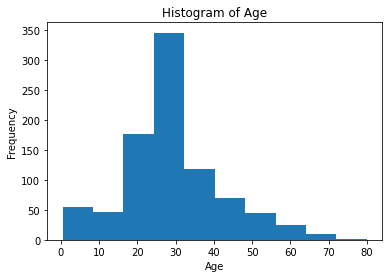

In [8]:
# Show histogram of Age
plt.hist(train_df['Age'], 10)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

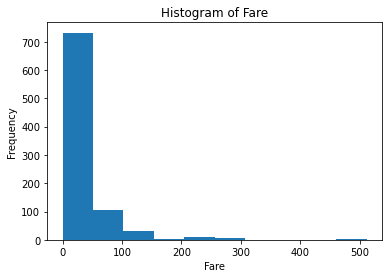

In [9]:
# Show histogram of Fare
plt.hist(train_df['Fare'], 10)
plt.title('Histogram of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')

In [10]:
# Calculate the percent of women that survived
women = train_df.loc[train_df.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)

# Calculate the percent of men that survived
men = train_df.loc[train_df.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)

print(f"{rate_women *100:.2f}% of women survived")
print(f"{rate_men * 100:.2f}% of men survived")

74.20% of women survived
18.89% of men survived


In [11]:
# Show percentage of passangers who survived over 40
over_40 = train_df.loc[train_df.Age > 40]['Survived']
over_40_calc = sum(over_40)/len(over_40)
print(f"{over_40_calc * 100:.2f}% of passangers over 40 survived")

36.67% of passangers over 40 survived


In [12]:
# Show percentage of passengers with fares lower than the mean that survived
lower_fares = train_df.loc[train_df.Fare < train_df['Fare'].mean()]['Survived']
lower_fares_calc = sum(lower_fares)/len(lower_fares)
print(f"{lower_fares_calc * 100:.2f}% of passangers who paid lower fares survived")

31.76% of passangers who paid lower fares survived


The sections below bin the age, family and fare variables. 

In [13]:
# Bin the age variable 
train_df['ageBinned'] = pd.cut(train_df['Age'], bins=[0,18,35,65,85], labels=["Child", "Young Adult", "Adult", "Elderly"])
test_df['ageBinned'] = pd.cut(test_df['Age'], bins=[0,18,35,65,85], labels=["Child", "Young Adult", "Adult", "Elderly"])

# Show mean and max fare
print(f"The average fare is {train_df['Fare'].median():.2f}")
print(f"The max fare is {train_df['Fare'].max():.2f}")

# Show mean and max family size
print(f"The average family size is {train_df['Family'].median() + 1:.0f}")
print(f"The max family size is {train_df['Family'].max() + 1}")

The average fare is 14.45
The max fare is 512.33
The average family size is 1
The max family size is 11


In [14]:
# Bin the fare variable 
train_df['fareBinned'] = pd.cut(train_df['Fare'], bins=[0,10,25,513], labels=["Low", "Average", "High"])
test_df['fareBinned'] = pd.cut(test_df['Fare'], bins=[0,10,25,513], labels=["Low", "Low/Average", "High"])

# Bin the family variable 
train_df['familyBinned'] = pd.cut(train_df['Family'], bins=[0,1,2,3], labels=["None", "Small family", "Large family"])
test_df['familyBinned'] = pd.cut(test_df['Family'], bins=[0,1,2,3], labels=["None", "Small family", "Large family"])

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,ageBinned,fareBinned,familyBinned
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Young Adult,Low,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Adult,High,None
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Young Adult,Low,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Young Adult,High,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Young Adult,Low,NaN


In [15]:
# Separate training and validation sets
train_data = train_df.sample(frac=0.85, random_state=0)
val_data = train_df.drop(train_data.index)

# Drop labels from validation set
val_labels = val_data["Survived"]
val_data = val_data.drop("Survived", 1)

# Print size of new training and validation sets
print(f"Training Rows: {train_data.shape[0]}, Training Cols: {train_data.shape[1]}")
print(f"Validation Rows: {val_data.shape[0]}, Validation Cols: {val_data.shape[1]}")

# Verify correct column dropped
val_data.head()

Training Rows: 757, Training Cols: 16
Validation Rows: 134, Validation Cols: 15


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,ageBinned,fareBinned,familyBinned
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,Child,High,None
23,24,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,0,Young Adult,High,NaN
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,28.0,0,0,330959,7.8792,NaN,Q,0,Young Adult,Low,NaN
42,43,3,"Kraeff, Mr. Theodor",male,28.0,0,0,349253,7.8958,NaN,C,0,Young Adult,Low,NaN
47,48,3,"O'Driscoll, Miss. Bridget",female,28.0,0,0,14311,7.7500,NaN,Q,0,Young Adult,Low,NaN


The features used in these models are gender, Pclass,fare, family, and age. The get_dummies command converts the categorical variables to numeric (dummy) variables. 

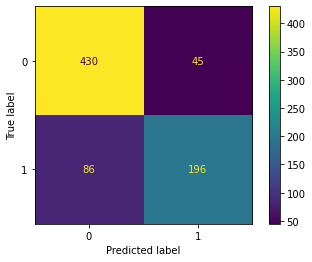

In [16]:
# Select features
features = ["Sex","fareBinned", "Pclass", "familyBinned", "ageBinned"]

# Separate training labels and make dummy variables of categoricals
y_train = train_data["Survived"]
x_train = pd.get_dummies(train_data[features])
x_val = pd.get_dummies(val_data[features])
x_test = pd.get_dummies(test_df[features])

# Fit model (Adding parameter from tuning below)
model1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1, min_samples_leaf = 2,
                              min_samples_split = 5)
model1.fit(x_train, y_train)

# Get train and val predictions 
train_predictions = model1.predict(x_train)
val_predictions = model1.predict(x_val)

# Confusion matrix for train predictions
plot_confusion_matrix(model1, x_train, y_train) 

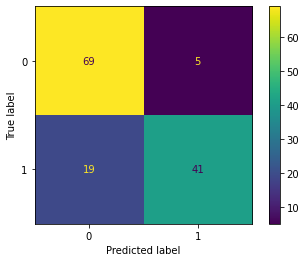

In [17]:
# Confusion matrix for validation set
plot_confusion_matrix(model1, x_val, val_labels) 

In [18]:
# Print training and test accuracy (Random forest)
print(f"Training Accuracy: {metrics.accuracy_score(y_train, train_predictions) * 100:.2f}%")
print(f"Validation Accuracy: {metrics.accuracy_score(val_labels, val_predictions) * 100:.2f}%")

Training Accuracy: 82.69%
Validation Accuracy: 82.09%


In [19]:
# Try logistic regression 
model2 = LogisticRegression(solver='liblinear', random_state=0)
model2.fit(x_train, y_train)
train_predictions = model2.predict(x_train)
val_predictions = model2.predict(x_val)

# Print classifcation report train
print(classification_report(y_train, train_predictions))

# Print classification report val
print(classification_report(val_labels, val_predictions))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       475
           1       0.76      0.68      0.72       282

    accuracy                           0.80       757
   macro avg       0.79      0.78      0.78       757
weighted avg       0.80      0.80      0.80       757

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        74
           1       0.83      0.73      0.78        60

    accuracy                           0.81       134
   macro avg       0.82      0.81      0.81       134
weighted avg       0.81      0.81      0.81       134



In [20]:
# Copyright: Open Data Science
# Tune decision tree params

# Define test parameters
n_estimators = [50, 100, 500, 1000, 1500]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [5, 10, 15, 20, 30]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]

# Define parameter grid
param_grid = {'n_estimators': n_estimators,
            'max_features' : max_features,
            'max_depth' : max_depth,
            'min_samples_split' : min_samples_split,
            'min_samples_leaf' : min_samples_leaf}

# Defined random forest regressor model
RFR = RandomForestRegressor(random_state = 1)
RFR_random = RandomizedSearchCV(estimator = RFR, 
                            param_distributions = param_grid,
                            n_iter = 100, cv = 5, verbose = 2,
                            random_state = 42, n_jobs = -1)

# Fit model
RFR_random.fit(x_train, y_train)
print(RFR_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min


{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


The random forest model performed slightly better than logistic regression. The recommended parameters from parameter tuning did not increase performance. Therefore, a max depth of 5 was better than 30. The final submission score was 78.4.

In [21]:
# Predict test set
test_predictions = model1.predict(x_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
